## IQM Resonance Example Notebook
In order to get started, make sure you have the appropriate packages installed. As prerequisite, you need to have **Python 3.11** or above and pip installed on your system.

You have chosen IQM Emerald as your quantum computer. The following code snippet also shows how to create an IQM client and connect to this specific device.

Run the cell and enter your IQM Resonance API token when prompted. You can find your API token in your IQM Resonance UI account drawer.
In order to install the packages and init the backend to work with IQM hardware in QRISP, run the following cell:

In [ ]:
import sys
import subprocess

# --- Check Python version ---
major, minor = sys.version_info[:2]

if not (major == 3 and minor == 12):
    print(f"❌ Python {major}.{minor} detected.")
    print("Please change the Colab runtime to **Python 3.11**:")
    print("Runtime → Change Runtime Type → Runtime Version → 2025.07")
    raise SystemExit

print(f"✅ Python {major}.{minor} detected (OK).")

# --- Check pip version ---
pip_version_output = subprocess.check_output(["pip", "--version"]).decode()
pip_version = pip_version_output.split()[1]  # e.g. "25.0"

print(f"Detected pip version: {pip_version}")

if not pip_version.startswith("25"):
    print("❌ pip version is not 25.x. Installing pip 25...")
    !pip install --upgrade pip==25.*
    print("✅ pip 25 installed.")
    print("Please RESTART the runtime now (Runtime → Restart session).")
else:
    print("✅ pip 25.x is already installed.")

✅ Python 3.12 detected (OK).
Detected pip version: 25.3
✅ pip 25.x is already installed.


In [ ]:
# install iqm-client with qrisp extras
!pip install -U "iqm-client>=33.0.1" "qrisp[iqm]"
# used for visualization
!pip install matplotlib

from qrisp.interface import IQMBackend
quantum_computer = IQMBackend(
    api_token = input("IQM Resonance API token"),
    device_instance = "sirius")


IQM Resonance API token5r9aiHGLmYhL8Duu3VR/UDiyXuCqJU8LDJMjreXUDQQBmxh1Z/l+0qPaZRueIor/


After successfully installing the required packages and initializing the backend, you can submit the quantum circuit.


{'000': 0.5, '111': 0.5}


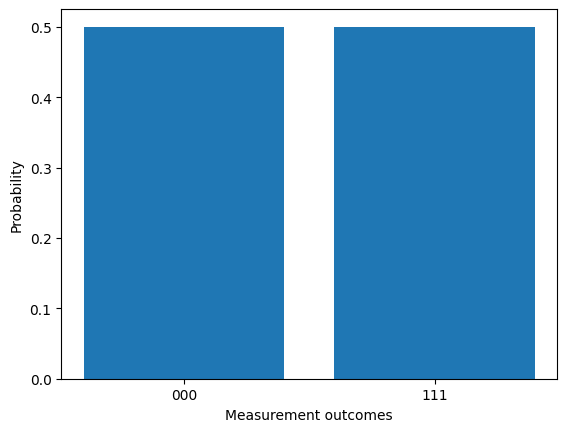

In [ ]:
from qrisp import *
from matplotlib import pyplot as plt

# This example creates a GHZ state, replace it with your own code
qv = QuantumVariable(3)
h(qv[0])
cx(qv[0], qv[1])
cx(qv[0], qv[2])

# Execute it on the quantum computing backend
# Transpilation is taken care of automatically
result = qv.get_measurement()

# Print and plot the result
print(result)

plt.bar(result.keys(), result.values())
plt.xlabel('Measurement outcomes')
plt.ylabel('Probability')
plt.show()

You have now successfully created a GHZ state on three qubits!.

A GHZ state is named after Daniel Greenberger, Michael Horne, and Anton Zeilinger, who first described this type of entangled quantum state. It is a specific type of multi-qubit entangled state with two possible measurement outcomes: all qubits being in the state 0 or all qubits being in the state 1. The GHZ state is represented mathematically as:
$$|GHZ_3⟩ = \frac{|000⟩ + |111⟩}{\sqrt{2}}$$

This state is significant in quantum information theory and quantum computing because it exhibits strong correlations between the qubits, which cannot be explained by classical physics (in particular, it contradicts local hidden variable theories).

You have successfully ran a quantum circuit. Please view the results in the IQM Resonance dashboard for further insights.

Go to the [IQM Resonance](https://resonance.meetiqm.com).

In [ ]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Optional
import random

import qrisp as qlib # Import your own quantum library

def create_ind():
    return [random.random() * 10 - 5, random.random() * 10 - 5, random.random() * 10 - 5]

def cost_operator(q, gamma, w1, w2, w3):
    # Termino Z0
    rz(2 * gamma * w1, q[0])

    # Termino Z1
    rz(2 * gamma * w2, q[1])

    # Termino Z0 Z1
    cx(q[0], q[1])
    rz(2 * gamma * w3, q[1])
    cx(q[0], q[1])

def mixer_operator(q, beta):
    rx(2 * beta, q[0])
    rx(2 * beta, q[1])

def quantum_best_move(soldier, enemy, genind):
    qv = QuantumVariable(2)
    d = soldier.distance_to(enemy)
    r = soldier.range_dist
    dr = d - r
    gamma = 0.85
    beta = 0.9

    cost_operator(qv, gamma, -genind[0] * dr, -genind[1] *d, -genind[2] *d*dr)
    mixer_operator(qv, beta)

    result = qv.get_measurement()
    stop = result['10'] + result['11']
    adv = result['01']

    nx = max(-1, min(1, enemy.x - soldier.x))
    ny = max(-1, min(1, enemy.y - soldier.y))

    if (stop > 0.5):
        # print(soldier.unit_type, result, 'r: ',stop)
        return (0,0)

    if (adv < 0.25):
        (nx, ny) = (-nx, -ny)
    else:
        if (soldier.x + nx == enemy.x and soldier.x + ny == enemy.y and nx != 0 and ny != 0):
            nx = 0
    # print(soldier.unit_type, result, 'n: ', nx, ny, 'adv: ',adv)
    return (nx, ny)


@dataclass
class Soldier:
    """Represents a single soldier on the battlefield."""
    x: float
    y: float
    strength: int  # 1, 2, 3 (low, medium, high)
    health: int    # 1, 2, 3 (low, medium, high)
    unit_type: str  # 'soldier', 'knight', 'archer'
    team: str  # 'Quantum' or 'Classical'
    range_dist: int  # 1, 2, 3 (low, medium, high)
    max_health: int = None  # Track original health for display

    def __post_init__(self):
        """Store max health after initialization."""
        if self.max_health is None:
            self.max_health = self.health

    def distance_to(self, other: 'Soldier') -> float:
        """Manhattan distance to another soldier."""
        return abs(self.x - other.x) + abs(self.y - other.y)

    def can_fight(self, other: 'Soldier') -> bool:
        """Check if this soldier can fight another."""
        return self.team != other.team and self.distance_to(other) <= self.range_dist

    def is_alive(self) -> bool:
        """Check if soldier is still alive."""
        return self.health >= 1

    def take_damage(self, damage: int):
        """Reduce health by damage amount. Health stays between 0 and 3."""
        self.health = max(0, min(3, self.health - damage))

    def attack(self, other: 'Soldier') -> int:
        """
        Attack another soldier and return damage dealt.
        Damage is based on strength (1, 2, or 3).
        Soldiers die when health drops below 1.
        """
        if not self.can_fight(other):
            return 0
        # Damage equals attacker's strength
        damage = self.strength
        other.take_damage(damage)
        return damage

class QuantumBattlefield:
    """Manages the battle simulation."""
    def __init__(self, width: int = 4, height: int = 4):
        self.width = width
        self.height = height
        self.board_size = width * height
        self.soldiers: List[Soldier] = []
        self.turn = 0
        self.history = {'team_a_count': [], 'team_b_count': [], 'turn': []}

    def add_soldier(self, soldier: Soldier):
        """Add a soldier to the battlefield."""
        self.soldiers.append(soldier)

    def initialize_team(self, team: str, composition: dict, start_x_range):
        """
        Initialize a team with given composition.

        Args:
            team: 'Quantum' or 'Classical'
            composition: {'unit_type': (count, strength, health, range_dist)}
            start_x_range: (x_min, x_max) for starting positions (inclusive)
        """
        # All possible x positions in the allowed range
        xs = []
        for r in start_x_range:
            xs += range(r[0], r[1] + 1)
        ys = range(self.height)

        # Create a list of all (x, y) pairs
        all_positions = [(x, y) for x in xs for y in ys]
        random.shuffle(all_positions)
        pos_index = 0

        for unit_type, (count, strength, health, range_dist) in composition.items():
            for _ in range(count):
                if pos_index >= len(all_positions):
                    print(f"Warning: Not enough positions for all units!")
                    break

                x, y = all_positions[pos_index]
                pos_index += 1

                soldier = Soldier(x, y, strength, health, unit_type, team, range_dist)
                self.add_soldier(soldier)

    def record_history(self):
        """Record current soldier counts for this turn."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        self.history['team_a_count'].append(count_a)
        self.history['team_b_count'].append(count_b)
        self.history['turn'].append(self.turn)

    def move_soldiers(self, team:str, genind):
        for soldier in self.soldiers:
            if not soldier.is_alive() or soldier.team != team:
                continue
            if soldier.team == "Quantum":
                # take the best posible move
                # the function must return a tuple best_move = (x,y) based on the current position of the soldier
                # it can accept any desired extra argument
                best_move = quantum_best_move(soldier, self._find_nearest_enemy(soldier), genind)
            else:
                # the classical team moves using random walks
                best_move = (random.randint(-1, 1), random.randint(-1, 1))

            # clip to the grid
            new_x = max(0, min(self.width - 1, soldier.x +best_move[0]))
            new_y = max(0, min(self.height - 1, soldier.y + best_move[1]))
            # update position
            # if not self._is_position_occupied_by_teammate(new_x, new_y, soldier):
            if not self._is_position_occupied(new_x, new_y):
                # Update position only if not occupied by teammate
                soldier.x, soldier.y = new_x, new_y

    def _find_nearest_enemy(self, soldier: Soldier) -> Optional[Soldier]:
        """Find the nearest enemy soldier."""
        enemies = [s for s in self.soldiers if s.team != soldier.team and s.is_alive()]
        if not enemies:
            return None
        return min(enemies, key=lambda e: soldier.distance_to(e))

    def _is_position_occupied(self, x:float, y:float) -> bool:
        for s in self.soldiers:
            if s.x == x and s.y == y:
              return True
        return False

    def _is_position_occupied_by_teammate(self, x: float, y: float, soldier: Soldier) -> bool:
        """Check if a position is occupied by a teammate."""
        for other in self.soldiers:
            if other is not soldier and other.is_alive() and other.team == soldier.team:
                if other.x == x and other.y == y:
                    return True
        return False

    def resolve_combat(self, team:str):
        """
        Resolve all combats this turn.
        Each soldier attacks enemies in range based on their strength.
        Soldiers die when health reaches 0.
        """
        combat_pairs = []

        # Find all valid combat pairs
        for i, attacker in enumerate(self.soldiers):
            if not attacker.is_alive() or attacker.team != team:
                continue

            # Find enemies in range
            targets = [s for s in self.soldiers if attacker.can_fight(s) and s.is_alive()]

            if targets:
                # Attack the weakest enemy in range (lowest current health)
                target = min(targets, key=lambda s: s.health)
                combat_pairs.append((attacker, target))

        # Execute all attacks
        for attacker, defender in combat_pairs:
            if attacker.is_alive() and defender.is_alive():
                attacker.attack(defender)

        # Remove dead soldiers
        self.soldiers = [s for s in self.soldiers if s.is_alive()]

    def step(self, team:str, genind):
        """Execute one turn of the battle."""
        self.move_soldiers(team, genind)
        self.resolve_combat(team)
        self.turn += 1
        self.record_history()

    def is_battle_over(self) -> bool:
        """Check if battle has ended."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        return count_a == 0 or count_b == 0

    def get_winner(self) -> str:
        """Return 'Quantum', 'Classical', or None."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        if count_a == 0 and count_b == 0:
            return None
        if count_a == 0:
            return 'Classical'
        if count_b == 0:
            return 'Quantum'
        return None

    def get_survivor_count(self) -> Tuple[int, int]:
        """Return (team_a_survivors, team_b_survivors)."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        return count_a, count_b

def visualize_battle(battlefield: QuantumBattlefield, save_path: str = None):
    """Create a static visualization of the battlefield with unit types as markers."""
    fig, ax = plt.subplots()

    # Define markers for unit types
    markers = {'soldier': 'o', 'knight': 's', 'archer': '^'}
    colors = {'Quantum': 'royalblue', 'Classical': 'firebrick'}

    # Plot each combination of team and unit type
    for team in ['Quantum', 'Classical']:
        for unit_type, marker in markers.items():
            soldiers = [s for s in battlefield.soldiers
                       if s.team == team and s.unit_type == unit_type]
            if soldiers:
                ax.scatter([s.x for s in soldiers], [s.y for s in soldiers],
                          c=colors[team], marker=marker, s=100, alpha=0.7,
                          label=f'Team {team} - {unit_type}', edgecolors='black', linewidth=0.5)

    ax.set_xlim(-0.1, battlefield.width - 1  + 0.1)
    ax.set_xticks([x for x in range(battlefield.width)])
    ax.set_xticklabels([])
    ax.set_ylim(-0.1, battlefield.height - 1 + 0.1)
    ax.set_yticks([x for x in range(battlefield.height)])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.tick_params(axis='both', direction='in')
    ax.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_history(battlefield: QuantumBattlefield, save_path: str = None):
    """Plot team sizes over time."""
    plt.figure()
    plt.plot(battlefield.history['turn'], battlefield.history['team_a_count'],
             label='Team Quantum', color='royalblue', linewidth=2)
    plt.plot(battlefield.history['turn'], battlefield.history['team_b_count'],
             label='Team Firebrick', color='firebrick', linewidth=2)
    plt.xlabel('Turn')
    plt.xticks(battlefield.history['turn'])
    plt.ylabel('Soldier Count')
    plt.title('Team Size Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
    plt.show()

def crossover(parent1, parent2):
    child = create_ind()
    for i in range(len(child)):
        if random.random() > 0.5:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < 0.1:
            individual[i] += random.random() * 0.1 - 0.05
    return individual



In [ ]:

width, height = 6, 4
comp = {
    'soldier': (1, 2, 3, 1),
    'knight':  (1, 3, 3, 1),
    'archer':  (1, 1, 2, 3),
}
maps = [
    [[(0, 1)], [(width - 2, width - 1)]],           #in front
    [[(width - 2, width - 1)], [(0, 1)]],           #in front (reversed)
    [[(width / 2 - 1, width / 2)], [(0, 0), (width - 1, width - 1)]] # surrounded
]
mapi = 1

N_INDIVIDUALS = 50
#population = [create_ind() for _ in range(N_INDIVIDUALS)]
population = [[-0.8834381465458518, -1.759750208282166, -1.8863862392649775], [-3.4313399658998742, 0.5003633746088951, -3.972310260368487], [-0.40926806675363814, 2.3174379291311977, 1.197233475468881], [-1.2299599810851922, 2.2911417550261994, 3.9959924511183296], [1.045171621912755, 2.499519818395134, 1.784222779025213], [-1.3550895720312175, -2.0018652656494105, -4.329715727730656], [0.27332958006119323, 1.3733240359917307, 2.2048766256286934], [-4.177742379536209, 3.17120575622911, 3.9893226409245717], [-3.756705343259407, 3.400144034945944, -2.7335588202527528], [-3.3541609213648393, 0.6686347603443394, 1.487880350703823], [4.16533419270637, 2.4006248102642775, 3.6414965007817752], [4.1045493402222295, 1.280474476805714, 1.2334264190763768], [3.7227465412469467, -3.469851695642241, -3.621645211272778], [1.5058983645956756, 4.653133910398804, 3.574860574275789], [-1.386179803605354, 4.354464676209405, 0.39793910021411705], [-3.54948708897778, -4.360175605188963, -1.2168151110838874], [0.055076252323757124, 4.8431059634789495, -2.884053643641993], [-0.26004245644528545, 2.2858082139483074, 3.0265773351276977], [-0.3822661091250543, 0.8527414168397163, -0.11535480159225475], [-4.733438209349755, -2.0816744007762944, -4.378280025360736], [0.6467857223017583, -2.0072985155629643, -3.5162714835702067], [1.6678791516812872, -2.0141283115702913, -2.3374105613079745], [2.7555942148416737, 2.4480303042989515, -0.21733911132171624], [0.979584765438207, -2.722494215620106, 3.7234337967695534], [-3.3557085787364125, 0.15298309229201923, -0.6587162615209206]]
while len(population) < N_INDIVIDUALS:
    population.append(create_ind())

scores = [0 for _ in range(N_INDIVIDUALS)]

REPS = 51
# for k in range(REPS):
k = 0
while True:
    k += 1
    for gen in range(N_INDIVIDUALS):
        battlefield = QuantumBattlefield(width=width, height=height)

        battlefield.initialize_team(
            team='Quantum',
            composition=comp,
            start_x_range=maps[mapi][0]
        )

        battlefield.initialize_team(
            team='Classical',
            composition=comp,
            start_x_range=maps[mapi][1]
        )

        # visualize_battle(battlefield)
        max_turns = 10
        for _ in range(max_turns):
            if battlefield.is_battle_over():
                break
            battlefield.step('Quantum', population[gen])
            # print('Quantum')
            # visualize_battle(battlefield)
            battlefield.step('Classical', population[gen])
            # print('Classical')
            # visualize_battle(battlefield)

        # visualize_battle(battlefield)
        if k % 6 == 0 and gen == 0:
            print(k)
            plot_history(battlefield)

        winner = battlefield.get_winner()
        q_survivors, c_survivors = battlefield.get_survivor_count()

        scores[gen] = q_survivors - c_survivors
        # print('scores: ', sorted(scores, reverse=True))
        population = [v for _, v in sorted(zip(scores, population), key=lambda x: x[0], reverse=True)]


    best = [x for x in population[:N_INDIVIDUALS // 2]]
    print(best)
    npop = [best[0]]
    for i in range(0, len(best) - 1, 2):
        child = crossover(best[i], best[i + 1])
        child = mutate(child)
        npop.append(child)
    while len(npop) < N_INDIVIDUALS:
        npop.append(create_ind())
    population = npop




KeyboardInterrupt: 